In [1]:
#!/usr/bin/python3
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    Parser,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    PointCloud,
    MeshcatPointCloudVisualizer,
    BaseField,
    Fields,
    Rgba
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem
from pydrake.solvers import MathematicalProgram, Solve

import quadrotor_params as p

from trajectory_generator import TrajectoryGenerator
import waypoint_library
from differential_flatness import trajectory_to_state
import trajectory_controller
from utils import constant_rotation_headings, waypoints_to_point_cloud

In [2]:
PSI_F = 0.0*np.pi
waypoints = waypoint_library.waypoints_fig_8
num_wp = waypoints.shape[1]
headings = constant_rotation_headings(num_wp, PSI_F)

traj_gen = TrajectoryGenerator(waypoints, headings)
traj_gen.solve()

dt = .001
t = np.arange(0.0, traj_gen.tf, dt)

# CONTROLLED

In [3]:
running_as_notebook = True
meshcat = StartMeshcat()
builder = DiagramBuilder()
waypoint_vis = waypoints_to_point_cloud(waypoints, p.keyframes_pts_per_edge, p.keyframes_half_width)

plant = builder.AddSystem(QuadrotorPlant(
    m_arg=p.m_kg,
    L_arg=p.L_m,
    I_arg=p.J,
    kF_arg=p.kF,
    kM_arg=p.kM
))

props = [Variable(f'p{i}') for i in range(4)]
controller = builder.AddSystem(SymbolicVectorSystem(state=props, dynamics=np.zeros(4), output=props))
builder.Connect(controller.get_output_port(0), plant.get_input_port(0))

# Set up visualization in MeshCat
scene_graph = builder.AddSystem(SceneGraph())


QuadrotorGeometry.AddToBuilder(
    builder, plant.get_output_port(0), scene_graph
)
meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty("/Background", "visible", False)
# kXYZs=np.array([[0., 0., 0.]])
point_cloud = PointCloud(new_size=len(t), fields=Fields(BaseField.kXYZs))
thing = point_cloud.mutable_xyzs()
for i, ti in enumerate(t):
    thing[:,i] = traj_gen.eval_trajectory(ti, 0)
# thing[:,:] = np.zeros((3,len(t)))
# thing[0,:] = np.arange(len(t))*1/len(t)
# thing[1,:] = np.arange(len(t))*1/len(t)

meshcat.SetObject("/point_cloud/", point_cloud, point_size=.05, rgba=Rgba(1.0, 0.0, 0.5, 1.0))
meshcat.SetObject("/waypoints/", waypoint_vis, point_size=.05, rgba=Rgba(0.0, 0.5, 0.5, 1.0))
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
# end setup for visualization

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
context = simulator.get_mutable_context()
# print(context.GetInputPort())



INFO:drake:Meshcat listening for connections at http://localhost:7003


In [4]:
# Simulate
K_p = 100*np.eye(3)
K_v = 100*np.eye(3)
K_R = 10*np.eye(3)
# K_R[2,2] = 1
K_omega = 10*np.eye(3)
# K_omega[2,2] = 1

for i in range(1):
    context.SetTime(0.0)
    simulator.Initialize()

    controller_context = diagram.GetMutableSubsystemContext(controller, context)
    controller_state = controller_context.get_mutable_continuous_state_vector() #.SetFromVector(np.array([0.25, 0.25, 0.25, 0.25])*9.8)
    context.SetContinuousState(np.concatenate([trajectory_to_state(traj_gen.eval_full_trajectory(0.0), plant).reshape(-1), np.zeros(4)]))

    state_list = []
    traj_list = []
    t_so_far = []
    motor_dist = np.zeros((4,1))
    motor_dist = 1.0*np.random.randn(4,1)

    for ti in t[0:]:
        simulator.AdvanceTo(ti)
        traj_matrix = traj_gen.eval_full_trajectory(ti)
        # traj_matrix = np.zeros((4,5))
        # traj_state = trajectory_to_state(traj_matrix, plant)
        # state = context.get_mutable_continuous_state_vector().CopyToVector().reshape((16,1))[:12,:]
        # state += np.vstack([np.zeros((6,1)), np.random.multivariate_normal(np.zeros(3), cov=.05*np.eye(3)).reshape((3,1)), np.random.multivariate_normal(np.zeros(3), cov=.05*np.eye(3)).reshape((3,1))])
        state = context.get_continuous_state_vector().CopyToVector().reshape((16,1))[:12,:]
        # state[2,0] = -state[2,0]
        # state[8,0] = -state[8,0]
        # print(state)
        motor_outputs = trajectory_controller.update(traj_matrix, state, plant, K_p, K_v, K_R, K_omega)
        motor_noise = 1.0*np.random.randn(4,1)
        motor_outputs += motor_noise + motor_dist
        controller_state.SetFromVector(motor_outputs)

        t_so_far.append(ti)
        state_list.append(state.reshape(-1))
        state_des = trajectory_to_state(traj_matrix, plant)
        traj_list.append(state_des.reshape(-1))


        # context.SetContinuousState(x_part)

In [5]:
context.SetTime(0.0)
simulator.Initialize()

context.SetContinuousState(np.concatenate([np.array([10, 0, 5, 0., 0., 0, 0, 0, 0, 0, 0, 0]).reshape(-1), np.zeros(4)]))
simulator.AdvanceTo(t[5])


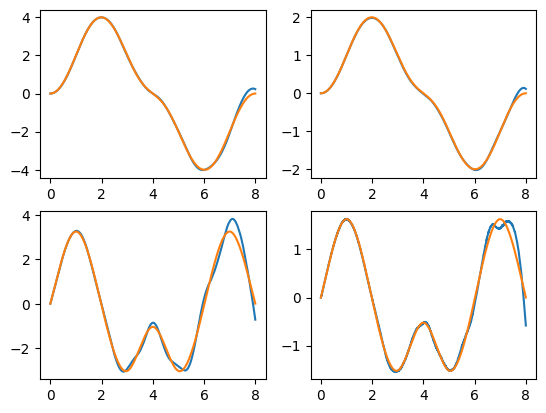

In [8]:
state_np = np.array(state_list)
traj_np = np.array(traj_list)

fig, axs = plt.subplots(2,2)
n = min(len(t_so_far), len(state_np[:,2]))
n = min(n, len(traj_np[:,2]))
axs[0,0].plot(t_so_far[:n], state_np[:,0][:n])
axs[0,0].plot(t_so_far[:n], traj_np[:,0][:n])
axs[0,1].plot(t_so_far[:n], state_np[:,2][:n])
axs[0,1].plot(t_so_far[:n], traj_np[:,2][:n])

axs[1,0].plot(t_so_far[:n], state_np[:,6][:n])
axs[1,0].plot(t_so_far[:n], traj_np[:,6][:n])
axs[1,1].plot(t_so_far[:n], state_np[:,8][:n])
axs[1,1].plot(t_so_far[:n], traj_np[:,8][:n])


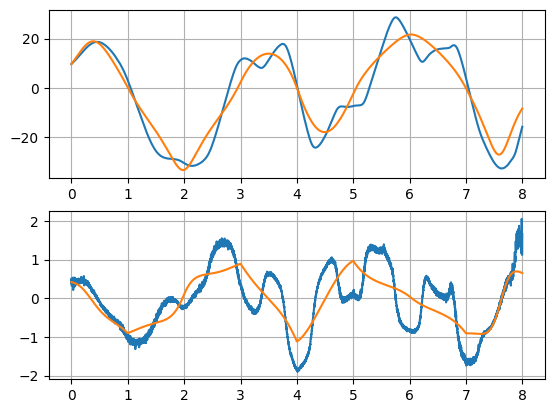

In [7]:
state_np = np.array(state_list)
traj_np = np.array(traj_list)

fig, axs = plt.subplots(2,1)
n = min(len(t_so_far), len(state_np[:,4]))
n = min(n, len(traj_np[:,4]))
axs[0].plot(t_so_far[:n], state_np[:,4][:n]*180/np.pi)
axs[0].plot(t_so_far[:n], traj_np[:,4][:n]*180/np.pi)

axs[1].plot(t_so_far[:n], state_np[:,10][:n])
axs[1].plot(t_so_far[:n], traj_np[:,10][:n])
# axs[0].set_ylim([-20,20])
# axs[1].set_ylim([-5,1])

axs[0].grid(True)
axs[1].grid(True)